In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib qt

In [16]:
def plot_figures(figures, nrows = 1, ncols=2):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    print(len(figures))
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title])
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

In [62]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    #print(len(titles))
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        a.set_axis_off()
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [37]:
import matplotlib.image as mpimg
images = glob.glob('test_images/*.jpg')
image_list = []
title_list = []
for fname in images:
    img = mpimg.imread(fname)
    file_name = fname.split("/")[1]
    undistort_img = mpimg.imread(os.path.join('output_images',fname))
    image_list.append(img)
    image_list.append(undistort_img)
    title_list.append(fname)
    title_list.append("output_images/" + fname)
show_images(image_list,len(image_list)/2,title_list)

In [5]:
def calibtrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
#     f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
#     f.tight_layout()
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)        
    #         undist = cv2.undistort(img,mtx,dist,None,mtx)
    #         ax1.imshow(img)
    #         ax1.set_title('Original Image',fontsize=50)
    #         ax2.imshow(undist)
    #         ax2.set_title('Undistorted Image',fontsize=50)
    return mtx, dist
mtx, dist = calibtrate_camera()
                                   
    

In [6]:
def undistort_images(path):
    images = glob.glob(path + '/*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        undist = cv2.undistort(img,mtx,dist,None,mtx)
        cv2.imwrite(os.path.join('output_images/',fname),undist)
undistort_images('test_images')
undistort_images('camera_cal')


In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output_video = 'project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(output_video, audio=False)

NameError: name 'process_image' is not defined

In [4]:
output_video = 'project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [32]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    x = 1 if orient == 'x' else 0
    y = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(gray,cv2.CV_64F,x,y,ksize=sobel_kernel)
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))
    grad_binary = np.zeros_like(sobel_scaled)
    grad_binary[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    sobel_mag = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    sobel_mag_abs = np.absolute(sobel_mag)
    sobel_mag_scaled = np.uint8(255*sobel_mag_abs/np.max(sobel_mag_abs))
    mag_binary = np.zeros_like(sobel_mag_scaled)
    mag_binary[(sobel_mag_scaled >= mag_thresh[0]) & (sobel_mag_scaled <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    sobel_abs_dir = np.arctan2(np.absolute(sobel_y),np.absolute(sobel_x))
    dir_binary = np.zeros_like(sobel_abs_dir)
    dir_binary[(sobel_abs_dir >= thresh[0]) & (sobel_abs_dir <= thresh[1])] = 1
    return dir_binary
def color_threshold(img,thresh):
    hls_img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    S = hls_img[:,:,2]
    binary = np.zeros_like(S)
    binary[(S >= thresh[0]) & (S <= thresh[1])]=1
    return binary

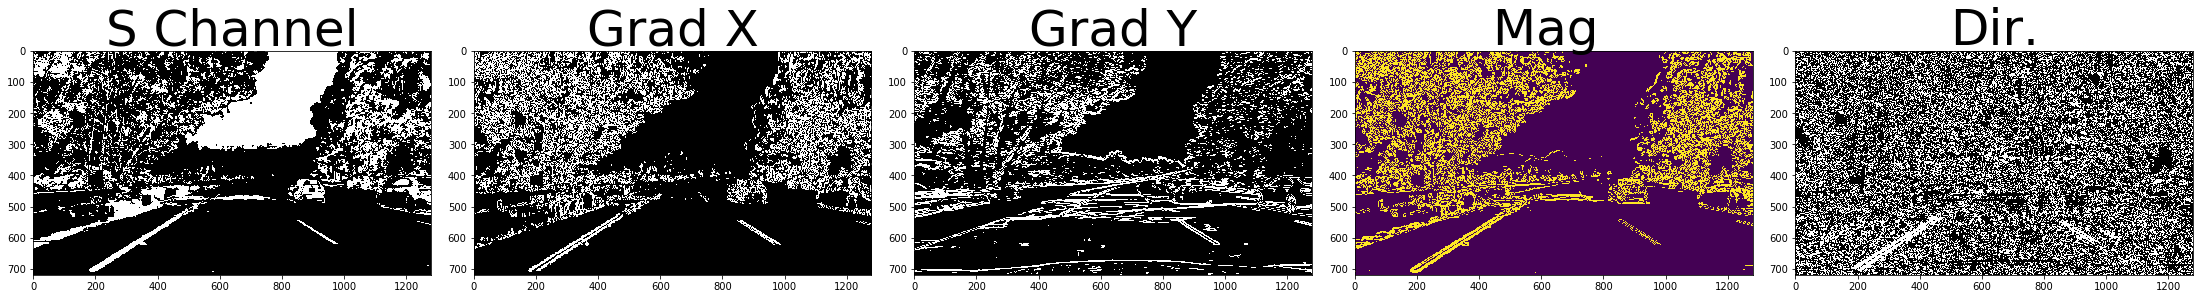

In [41]:
image = cv2.imread('output_images/test_images/test5.jpg')
ksize = 11
S_binary = color_threshold(image,(90,255))
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
hls_img = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
S_channel = hls_img[:,:,2]
gradx = abs_sobel_thresh(S_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(S_channel, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(S_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))

f, (ax0,ax1, ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(30, 12))
f.tight_layout()
ax0.imshow(S_binary,cmap='gray')
ax0.set_title('S Channel',fontsize=50)
ax1.imshow(gradx,cmap='gray')
ax1.set_title('Grad X', fontsize=50)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Grad Y', fontsize=50)

ax3.imshow(mag_binary)
ax3.set_title('Mag ', fontsize=50)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

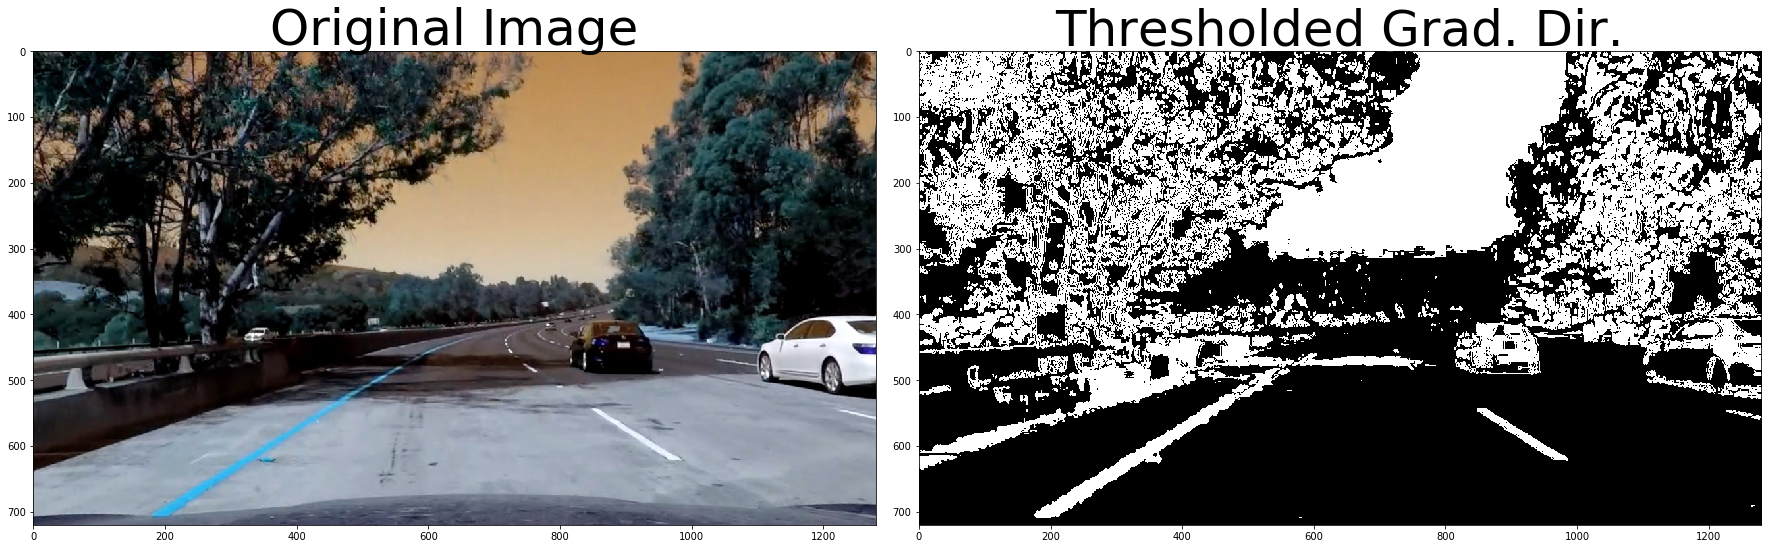

In [52]:
combined = np.zeros_like(gradx)
combined1 = np.zeros_like(gradx)

#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((S_binary == 1 ) | (gradx == 1))] = 1
#combined1[((S_binary == 1 ) | (gradx == 1))] = 1

#print(combined.shape)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [72]:
image = cv2.imread('output_images/test_images/test5.jpg')
img_size = image.shape[0:2:][::-1]
print(img_size)
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
print(src)
print(dst)

(1280, 720)
[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


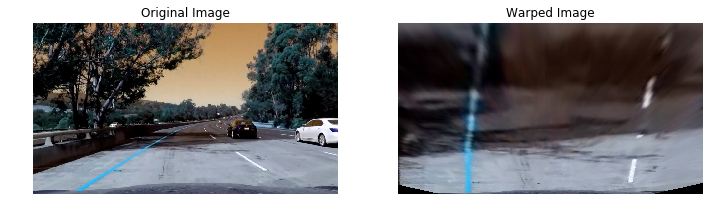

In [74]:
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
#warped_image = cv2.warpPerspective(image,M,img_size,flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
show_images([image,warped],1,['Original Image','Warped Image'])